# Assignment 3: CudaVision (From Q4)
------
### Group Members:
__1.__ Saikat Roy

__2.__ Albert Gubaidullin

## Import Dependencies
------

In [0]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import dataloader, random_split

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

import time

## Softmax Regression MLP object
------
The `SoftmaxRegressionMLP` class is a basic object to create a MLP with ReLU hidden units and a linear output unit (argmax(x) is the same as argmax(softmax(x)). Options while initializing include those of type of non-linearity and the number of layer and number of hidden units.

In [0]:
class SoftmaxRegressionMLP(nn.Module):

    def __init__(self, n_input, n_hidden_layers, n_output, h_units, t_hidden, drop):
        """
        Initialization for a simply softmax regression MLP model with ReLU activations in hidden layers
        :param n_input (int): Number of input units to network
        :param n_hidden_layers (int): Number of hidden layers in network
        :param n_output (int): Number of output units of network
        :param t_hidden (string): Type of hidden units in the network
        :param h_units (int or list): hidden unit count or list of hidden units in each hidden layer of network
        """
        super(SoftmaxRegressionMLP, self).__init__()
        self.n_out = n_output

        layers = []

        def add_layer_and_act(n_inp, n_out, nl_type, drop=0.2):
            layer_list = []
            if nl_type is None:
                layer_list.extend([nn.Linear(n_inp, n_out)])
            else:
                layer_list.extend([nn.Linear(n_inp, n_out), self.non_lin(nl_type)])
            
            if drop is not None:
                layer_list.extend([nn.Dropout(drop)])
            return layer_list

        # Add input layers
        if type(h_units) is list:
            layers.extend(add_layer_and_act(n_input, h_units[0], t_hidden, drop))
        else:
            layers.extend(add_layer_and_act(n_input, h_units, t_hidden, drop))

        # Add hidden layers
        if n_hidden_layers>1:
            for i in range(1, n_hidden_layers):
                if type(h_units) is list:
                    layers.extend(add_layer_and_act(h_units[i-1], h_units[i], t_hidden, drop))
                else:
                    layers.extend(add_layer_and_act(h_units, h_units, t_hidden, drop))

        # Add output layer
        if type(h_units) is list:
            layers.extend(add_layer_and_act(h_units[-1], self.n_out, None, None))
        else:
            layers.extend(add_layer_and_act(h_units, self.n_out, None, None))
        
#         print(*layers)
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        """
        Simple forward pass
        :param x:
        :return:
        """
        return self.block(x)

    def non_lin(self, nl_type='sigmoid'):
        """
        Simply plugs in a predefined non-linearity from a dictionary to be used throughout the network
        :param nl_type: type based on predefined types. Defaults to sigmoid on wrong type.
        :return:
        """
        nl = {'sigmoid': nn.Sigmoid(), 'relu': nn.ReLU(), 'tanh':nn.Tanh(), 'softmax': nn.Softmax(self.n_out)}
        try:
            return nl[nl_type]
        except:
            print("non linearity type not found. Defaulting to sigmoid.")
            return

## Method for calculating accuracy
------
The `acc` method simply calculates the predictive accuracy of a model on the given dataloader. It returns the true labels, predicted labels and the accuracy as a float in the range [0,1]

In [0]:
def acc(dataloader):
    """
    Calculate accuracy of predictions from model for dataloader.
    :param dataloader: dataloader to evaluate
    :return:
    """
    acc = 0.0
    true_y = []
    pred_y = []
    total = 0.0
    model.eval()
    with torch.no_grad():
        for batch_id, (x, y) in enumerate(dataloader):
            x = x.cuda()
            y = y.cuda()
            x = x.view(batch_size, -1)
            # print(x[0])
            preds = model(x)
            preds = torch.argmax(preds, dim=1)
            acc += ((preds==y).sum().item())
            total+= y.size(0)

            true_y.extend(list(preds.view(-1).cpu().numpy()))
            pred_y.extend(list(y.view(-1).cpu().numpy()))

        acc/=total
    return true_y, pred_y, acc

## Method for training model in PyTorch
------
The `train` method takes a dataloader object and trains the model on it for the specified amount of iterations and returns the loss per iteration as a list. Also calculates the accuracy on the training validation set per epoch.

In [0]:
def train(train_dataloader, valid_dataloader, iters = 20, suppress_output=False):
    """
    Trains the model on the given dataloader and returns the loss per epoch
    :param dataloader: The autoencoder is trained on the dataloader
    :param iters: iterations for training
    :return:
    """

    loss_l = []
    train_acc_l = []
    valid_acc_l = []
    for itr in range(iters):
        av_itr_loss = 0.0
        model.train()
        for batch_id, (x, y) in enumerate(train_dataloader):
            optimizer.zero_grad()
            # print(x)
            x = x.cuda()
            y = y.cuda()
            # x = (x>0.5).float() * 1
            x = x.view(batch_size, -1)
            # print(x[0])
            preds = model(x)
            # print((z==1).sum())
            batch_loss = loss(preds, y)
            batch_loss.backward()
            optimizer.step()
            av_itr_loss += (1/batch_size)*batch_loss.item()
        loss_l.append(av_itr_loss)
        if not suppress_output:
          if itr%1 == 0 or itr==iters-1:
            print("Epoch {}: Loss={}".format(itr, av_itr_loss))
        _, _, train_acc = acc(train_dataloader)
        _, _, valid_acc = acc(valid_dataloader)
        train_acc_l.append(train_acc)
        valid_acc_l.append(valid_acc)
    return loss_l, train_acc_l, valid_acc_l


## Method for plotting confusion matrix
------
__Please note that this function has been borrowed from the sklearn tutorial regarding the visualization of confusion matrices__. The function has however had minor modification to shorten its outputs and increase the figure size.

https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
"""
THIS CONFUSION MATRIX FUNCTION HAS BEEN BORROWED FROM THE SCIKIT-LEARN TUTORIAL ON GENERATING VISUAL CONFUSION MATRIX
PLOTS. REINVENTING THE WHEEL IN THIS CASE SEEMED TO BE EXTREMELY REDUNDANT.
"""

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     print(unique_labels(y_true, y_pred))
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#   print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Resize the subplots
    plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
#     fig.tight_layout()
    return ax

## Initializing Hyperparameters and Datasets
-------
The Dataloaders and some training hyperparameters are initialized. The neural network architecture used is __3072-128-128-10__ with 0.2 Dropout between layers (this is the best neural network we got from the previous experiments with the number of layers). Different types of non-linearities are tested later on the best model from here.

In [7]:
batch_size = 128
n_itr = 100
lr = 0.001

transform_list = transforms.Compose([#transforms.Grayscale(),
                                     transforms.ToTensor()])
trainset = datasets.CIFAR10('./data', train=True, download=True, transform=transform_list)
testset = datasets.CIFAR10('./data', train=False, download=True, transform=transform_list)

train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader  = torch.utils.data.DataLoader(testset,  batch_size=batch_size, shuffle=False, drop_last=True)

0it [00:00, ?it/s]

170500096it [00:08, 19566929.79it/s]                               


Files already downloaded and verified


## Training the model for different optimizers
------
The model is trained using `SGD`, `Adam`, `AdaGrad`, `AdaDelta` and `RMSProp` training algorithms. 


Training using Adam:
Epoch 0: Loss=6.0218543242663145
Epoch 1: Loss=5.506127002649009
Epoch 2: Loss=5.320775415748358
Epoch 3: Loss=5.200310909189284
Epoch 4: Loss=5.093967320397496
Epoch 5: Loss=5.023286403156817
Epoch 6: Loss=4.983091611415148
Epoch 7: Loss=4.927339819259942
Epoch 8: Loss=4.8691915245726705
Epoch 9: Loss=4.812361493706703
Epoch 10: Loss=4.793430655263364
Epoch 11: Loss=4.771197139285505
Epoch 12: Loss=4.733898069709539
Epoch 13: Loss=4.706377478316426
Epoch 14: Loss=4.6853870479390025
Epoch 15: Loss=4.651800035499036
Epoch 16: Loss=4.64232424646616
Epoch 17: Loss=4.6232000179588795
Epoch 18: Loss=4.593350791372359
Epoch 19: Loss=4.581917437724769
Epoch 20: Loss=4.56623525545001
Epoch 21: Loss=4.552196001634002
Epoch 22: Loss=4.533732453361154
Epoch 23: Loss=4.528985812328756
Epoch 24: Loss=4.500482939183712
Epoch 25: Loss=4.5080764116719365
Epoch 26: Loss=4.478667574934661
Epoch 27: Loss=4.485308717936277
Epoch 28: Loss=4.458958873525262
Epoch 29: Loss=4.46372176241

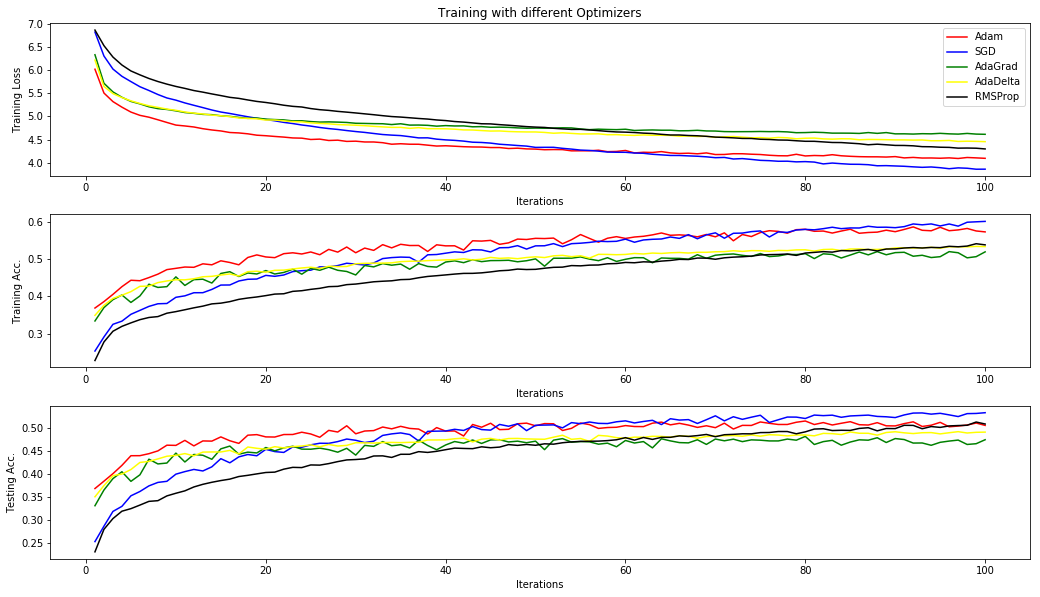

In [16]:
# torch.set_default_tensor_type(torch.cuda.FloatTensor)
loss_type = "Cross_Entropy"
optims = [torch.optim.Adam, torch.optim.SGD, torch.optim.RMSprop, torch.optim.Adagrad, torch.optim.Adadelta]
optim_names = ['Adam', 'SGD', 'AdaGrad', 'AdaDelta', 'RMSProp']
colors = ['red', 'blue', 'green', 'yellow', 'black']
lrs = [0.0005, 0.01, 0.001, 0.01, 0.01]
fig, axes = plt.subplots(3, 1)
fig.set_size_inches(16,12)
# print(axes)

for i in range(len(optims)):
    t1 = time.time()
    optim = optims[i]
    optim_name = optim_names[i]
    color = colors[i]
    lr = lrs[i]
    print("\nTraining using {}:".format(optim_name))

    model = SoftmaxRegressionMLP(1024*3, 2, 10, 128, 'relu', 0.2).cuda()
#     print(model)

    model.train()
    loss = nn.CrossEntropyLoss()
    optimizer = optim(model.parameters(), lr=lr)
    loss_list, train_acc, test_acc = train(train_dataloader, test_dataloader, iters=n_itr)
    t2 = time.time()
    print("Time to converge: {} sec".format(t2-t1))
    print("Final train accuracy={} and test accuracy={}".format(train_acc[-1],test_acc[-1]))
    
    axes[0].plot(np.linspace(1,n_itr,n_itr),loss_list, color=color, label = optim_name)
    axes[1].plot(np.linspace(1,n_itr,n_itr),train_acc, color=color, label = optim_name)
    axes[2].plot(np.linspace(1,n_itr,n_itr),test_acc, color=color, label = optim_name)
    
axes[0].set_xlabel("Iterations")
axes[1].set_xlabel("Iterations")
axes[2].set_xlabel("Iterations")

axes[0].set_ylabel("Training Loss")
axes[1].set_ylabel("Training Acc.")
axes[2].set_ylabel("Testing Acc.")

plt.subplots_adjust(top=0.92, bottom=0.3, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
#plt.legend(loc='best')
axes[0].legend(loc='upper right')

axes[0].set_title("Training with different Optimizers")
plt.savefig("loss.png", format='png', transparent=False, pad_inches=0.1)
plt.show()



# Training the model for different hidden unit non-linearities
------
The model is trained using `ReLU`, `Tanh` and `Sigmoid` non-linearities in the hidden units.


Training using ReLU activations in Hidden Layers:
SoftmaxRegressionMLP(
  (block): Sequential(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2)
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)
Epoch 0: Loss=6.030164762400091
Epoch 1: Loss=5.538488947786391
Epoch 2: Loss=5.3573511792346835
Epoch 3: Loss=5.220877165906131
Epoch 4: Loss=5.1329617612063885
Epoch 5: Loss=5.077867802232504
Epoch 6: Loss=5.0073217414319515
Epoch 7: Loss=4.963268526829779
Epoch 8: Loss=4.9078630823642015
Epoch 9: Loss=4.86364833265543
Epoch 10: Loss=4.837323294021189
Epoch 11: Loss=4.794661475345492
Epoch 12: Loss=4.778990047052503
Epoch 13: Loss=4.755565421655774
Epoch 14: Loss=4.720656266435981
Epoch 15: Loss=4.720137955620885
Epoch 16: Loss=4.685660266317427
Epoch 17: Loss=4.660511368885636
Epoch 18: Loss=4.646593837998807
Epoch 19: Lo

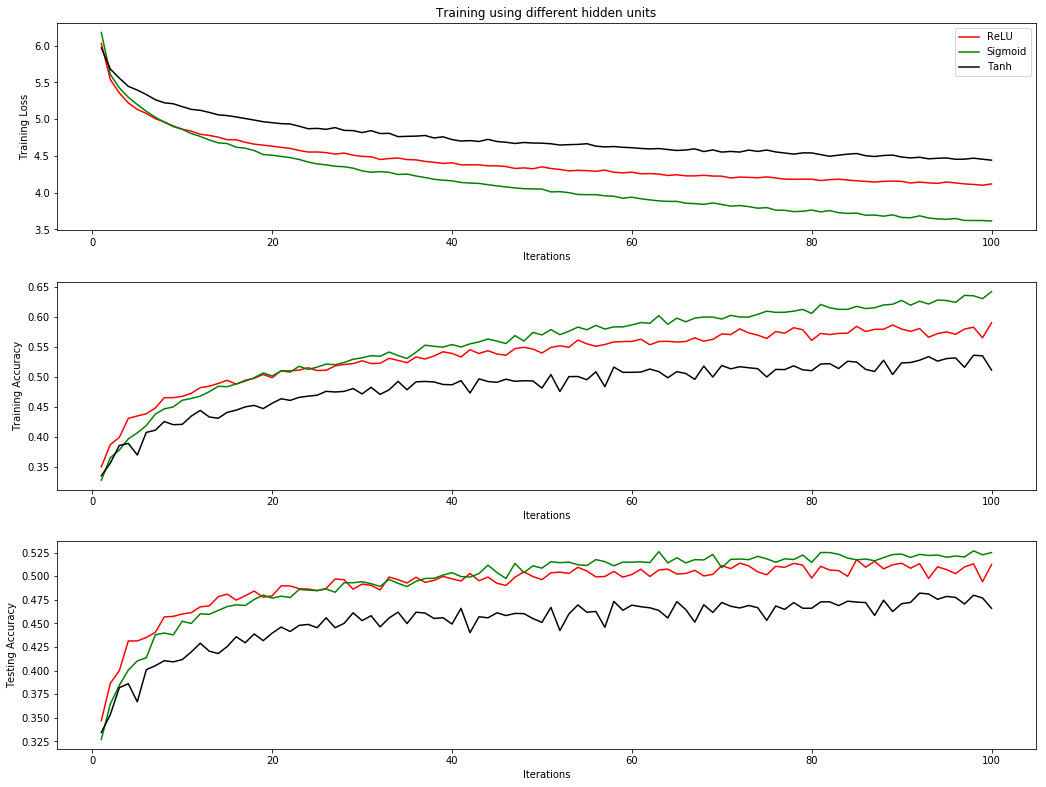

In [17]:
non_lins = ['relu', 'sigmoid', 'tanh']
non_lin_names = ['ReLU', 'Sigmoid', 'Tanh']
colors = ['red', 'green', 'black']
lrs = [0.0005, 0.001, 0.001]
fig, axes = plt.subplots(3, 1)

# Setting size of figures
fig.set_size_inches(16,12)
optim = torch.optim.Adam

for i in range(len(non_lins)): 
    lr = lrs[i]
    non_lin = non_lins[i]
    non_lin_name = non_lin_names[i]
    color = colors[i]
    print("\nTraining using {} activations in Hidden Layers:".format(non_lin_name))

    model = SoftmaxRegressionMLP(1024*3, 2, 10, 128, non_lin, 0.2).cuda()
    print(model)

    model.train()
    loss = nn.CrossEntropyLoss()
    optimizer = optim(model.parameters(), lr=lr)
    loss_list, train_acc, test_acc = train(train_dataloader, test_dataloader, iters=n_itr)
    
    print("Final train accuracy={} and test accuracy={}".format(train_acc[-1],test_acc[-1]))
    
    axes[0].plot(np.linspace(1,n_itr,n_itr),loss_list, color=color, label = non_lin_name)
    axes[1].plot(np.linspace(1,n_itr,n_itr),train_acc, color=color, label = non_lin_name)
    axes[2].plot(np.linspace(1,n_itr,n_itr),test_acc, color=color, label = non_lin_name)
    
axes[0].set_xlabel("Iterations")
axes[1].set_xlabel("Iterations")
axes[2].set_xlabel("Iterations")

axes[0].set_ylabel("Training Loss")
axes[1].set_ylabel("Training Accuracy")
axes[2].set_ylabel("Testing Accuracy")

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
axes[0].legend(loc='upper right')

axes[0].set_title("Training using different hidden units")
plt.savefig("loss.png", format='png', transparent=False, pad_inches=0.1)
plt.show()



# Softmax and Hinge Loss Functions without nn.Module
------
The Softmax and Hinge Loss Functions for a batch are defined without using the pre-built **loss** functions in Pytorch. The functions have been tested using the examples provided in the session 3. However, the functions are fully vectorized and usable with any Neural Network defined in pytorch.

In [0]:
def softmax_loss(pred_y, true_y, reduce='mean', individual=False):
  """
  Function for calculating softmax loss given the predictions and true values.
  One-hot conversion of classes not necessary for true_y. The loss is either
  averaged or summed over the batch.
  
  pred_y (tensor): Tensor of size batch_size X n_class of predictions for each 
                   class
  true_y (tensor): (tensor): Tensor of size batch_size of true class values. One
                   hot conversion is not needed.
  reduce (None or string): Default: 'mean'. Specifies whether loss is summed or 
                   averaged over mini-batch. If None, then no reduction is done.
  """
  
  pred_y = torch.exp(pred_y)
  
  true_y = true_y.type(torch.long) # Convert all values to torch.long
     
  den = torch.sum(pred_y, 1) # Calculate denominator
  num = pred_y.gather(1, true_y.unsqueeze(1)).squeeze(1) #Calculate numerator
  
  if reduce == 'mean':
    return -torch.mean(torch.log10(torch.div(num,den)))
  elif reduce == 'sum':
    return -torch.sum(torch.log10(torch.div(num,den)))
  else:
    if reduce is not None:
      print("Non-standard reduce. Treating as None.")
    return -torch.log10(torch.div(num,den))
  
  
def hinge_loss(pred_y, true_y, reduce='mean'):
  """
  Function for calculating hinge loss given the predictions and the true values
  One-hot conversion of classes not necessary for true_y. The loss is either
  averaged or summed over the batch.
  
  pred_y (tensor): Tensor of size batch_size X n_class of predictions for each 
                   class
  true_y (tensor): (tensor): Tensor of size batch_size of true class values. One
                   hot conversion is not needed.
  reduce (None or string): Default: 'mean'. Specifies whether loss is summed or 
                   averaged over mini-batch. If None, then no reduction is done.
  
  """
  true_y = true_y.type(torch.long) # Convert all values to torch.long

  d = pred_y.gather(1, true_y.unsqueeze(1)).squeeze(1) #Extract class values
  d = d-1.0 # Accumulating terms of difference (s_y - 1) for each row
  
  loss = pred_y - d[:,None] # Broadcasting to calculate difference of 
                            # s_j - (s_y - 1) for each row
  
  loss = torch.clamp(loss, min=0) # Implementing the max
  loss = torch.sum(loss,1) # Summing over class losses (columns) in each row
  
  loss = loss - 1 # Subtracting 1 for i==j for each row
  
  if reduce == 'mean':
    return torch.mean(loss)
  elif reduce == 'sum':
    return torch.sum(loss)
  else:
    if reduce is not None:
      print("Non-standard reduce. Treating as None.")
    return loss


## Using 2 Examples from lab class (session 3) with 'reduce' = None.
---------

In [55]:
# Using 2 Examples from class with 'reduce' = None
pred_y = torch.tensor([[ 3.2000,  5.1000, -1.7000],
        [-2.8500,  0.8600,  0.2800]])
true_y = torch.tensor([0.0, 2.0])

print("Class Predictions:\n {}".format(pred_y))
print("\nTrue Classes: {}".format(true_y))

print("\nSoftmax Loss:")
print(softmax_loss(pred_y, true_y, reduce=None))

print("\nHinge Loss:")
print(hinge_loss(pred_y, true_y, reduce=None))

Class Predictions:
 tensor([[ 3.2000,  5.1000, -1.7000],
        [-2.8500,  0.8600,  0.2800]])

True Classes: tensor([0., 2.])

Softmax Loss:
tensor([0.8861, 0.4517])

Hinge Loss:
tensor([2.9000, 1.5800])
